<a href="https://colab.research.google.com/github/khairyariqa/AlproII/blob/main/implementasi_cbai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ===== CELL 1: Import Library =====
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


In [ ]:
# ===== CELL 2: Load Data dari Google Drive =====
from google.colab import drive
drive.mount('/content/drive')

dataset_path = "/content/drive/MyDrive/dataset_full"
image_size = (224, 224)
batch_size = 32

Mounted at /content/drive


In [ ]:
# ===== CELL 3: Buat DataFrame Gambar & Label =====
all_images = []
all_labels = []

for label in sorted(os.listdir(dataset_path)):
    class_dir = os.path.join(dataset_path, label)
    if os.path.isdir(class_dir):
        for img_name in os.listdir(class_dir):
            if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                all_images.append(os.path.join(class_dir, img_name))
                all_labels.append(label)

data_df = pd.DataFrame({'filename': all_images, 'label': all_labels})

In [ ]:
# ===== CELL 4: Stratified Split (Train, Val, Test) =====
train_df, temp_df = train_test_split(data_df, test_size=0.3, stratify=data_df['label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

print("Jumlah per kelas (train):\n", train_df['label'].value_counts())
print("Jumlah per kelas (val):\n", val_df['label'].value_counts())
print("Jumlah per kelas (test):\n", test_df['label'].value_counts())

Jumlah per kelas (train):
 label
buah_sehat              350
cercospora_leaf_spot    350
antraknosa              350
daun_sehat              350
Name: count, dtype: int64
Jumlah per kelas (val):
 label
cercospora_leaf_spot    75
daun_sehat              75
antraknosa              75
buah_sehat              75
Name: count, dtype: int64
Jumlah per kelas (test):
 label
daun_sehat              75
cercospora_leaf_spot    75
buah_sehat              75
antraknosa              75
Name: count, dtype: int64


In [ ]:
# ===== CELL 5: ImageDataGenerator + Augmentasi =====
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=10,
    zoom_range=[0.95, 1.2],
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    brightness_range=[0.95, 1.05],
    horizontal_flip=True,
    fill_mode='reflect'
)

val_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_dataframe(
    train_df, x_col='filename', y_col='label',
    target_size=image_size, batch_size=batch_size,
    class_mode='categorical', shuffle=True
)

val_generator = val_test_datagen.flow_from_dataframe(
    val_df, x_col='filename', y_col='label',
    target_size=image_size, batch_size=batch_size,
    class_mode='categorical', shuffle=False
)

test_generator = val_test_datagen.flow_from_dataframe(
    test_df, x_col='filename', y_col='label',
    target_size=image_size, batch_size=batch_size,
    class_mode='categorical', shuffle=False
)

Found 1400 validated image filenames belonging to 4 classes.
Found 300 validated image filenames belonging to 4 classes.
Found 300 validated image filenames belonging to 4 classes.


In [ ]:
# ===== CELL 6: Visualisasi Augmentasi (Ralat untuk Display Aman) =====
vis_datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    horizontal_flip=True,
    rescale=1./255  # hanya untuk menampilkan agar gambar tidak rusak
)

vis_gen = vis_datagen.flow_from_dataframe(
    train_df, x_col='filename', y_col='label',
    target_size=image_size, batch_size=5,
    class_mode='categorical', shuffle=True
)

imgs, labs = next(vis_gen)

plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(imgs[i])
    label_index = np.argmax(labs[i])
    class_name = list(train_generator.class_indices.keys())[label_index]
    plt.title(f"Label: {class_name}")
    plt.axis('off')
plt.suptitle("Contoh Augmentasi + Label", fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
# ===== CELL 7: Modeling EfficientNetB0 + Regularizer =====
num_classes = len(train_generator.class_indices)  # FIX: Tentukan jumlah kelas dari class_indices

# ===== Transfer Learning =====
# Menggunakan EfficientNetB0 yang sudah dilatih di ImageNet
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.4)(x)
output = Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.001))(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,214,055 (16.08 MB)

 Trainable params: 164,484 (642.52 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
# ===== CELL 8: Fine-Tuning Optimal untuk Hindari Underfitting =====

# 1. Aktifkan training EfficientNet
base_model.trainable = True

# 2. Bekukan sebagian besar layer, latih 30 terakhir
for layer in base_model.layers[:-30]:
    layer.trainable = False

# 3. Tambahkan layer Dense dengan regulasi yang moderat
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)  # L2 lebih ringan
x = Dropout(0.5)(x)  # Dropout moderat, tidak terlalu agresif
output = Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.01))(x)

# 4. Susun model akhir
model = Model(inputs=base_model.input, outputs=output)

# 5. Kompilasi dengan learning rate kecil namun cukup untuk belajar
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 6. Callback untuk  dan pengurangan LR otomatis
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1)

# 7. Fine-tune dengan epoch cukup
history_finetune = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=8,  # Naikkan jika loss stabil
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/8
44/44 ━━━━━━━━━━━━━━━━━━━━ 655s 14s/step - accuracy: 0.2814 - loss: 3.8216 - val_accuracy: 0.4833 - val_loss: 3.6245
Epoch 2/8
44/44 ━━━━━━━━━━━━━━━━━━━━ 154s 4s/step - accuracy: 0.4541 - loss: 3.6307 - val_accuracy: 0.7133 - val_loss: 3.4318
Epoch 3/8
44/44 ━━━━━━━━━━━━━━━━━━━━ 207s 4s/step - accuracy: 0.5647 - loss: 3.5035 - val_accuracy: 0.8367 - val_loss: 3.2652
Epoch 4/8
44/44 ━━━━━━━━━━━━━━━━━━━━ 156s 4s/step - accuracy: 0.6605 - loss: 3.3541 - val_accuracy: 0.8867 - val_loss: 3.1241
Epoch 5/8
44/44 ━━━━━━━━━━━━━━━━━━━━ 178s 4s/step - accuracy: 0.7594 - loss: 3.2438 - val_accuracy: 0.9200 - val_loss: 3.0037
Epoch 6/8
44/44 ━━━━━━━━━━━━━━━━━━━━ 157s 4s/step - accuracy: 0.8039 - loss: 3.1387 - val_accuracy: 0.9367 - val_loss: 2.9042
Epoch 7/8
44/44 ━━━━━━━━━━━━━━━━━━━━ 222s 4s/step - accuracy: 0.8430 - loss: 3.0338 - val_accuracy: 0.9400 - val_loss: 2.8191
Epoch 8/8
44/44 ━━━━━━━━━━━━━━━━━━━━ 157s 4s/step - accuracy: 0.8639 - loss: 2.9601 - val_accuracy: 0.9500 - val_loss

In [ ]:
# ===== CELL 9 testing =====

loss, acc = model.evaluate(test_generator, verbose=0)
print(f"Akurasi Test: {acc * 100:.2f}%")
print(f"Loss Test: {loss:.4f}")


Akurasi Test: 94.33%
Loss Test: 2.7314


10/10 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step


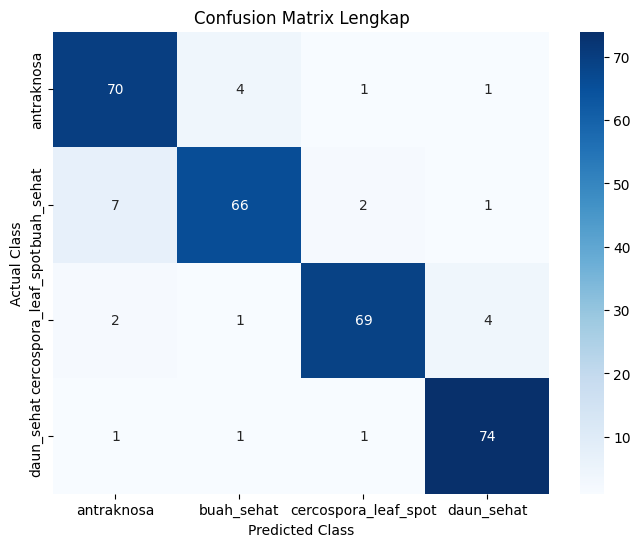


Classification Report:

                      precision    recall  f1-score   support

          antraknosa       0.89      0.93      0.91        75
          buah_sehat       0.94      0.88      0.91        75
cercospora_leaf_spot       0.95      0.92      0.93        75
          daun_sehat       0.95      0.99      0.97        75

            accuracy                           0.93       300
           macro avg       0.93      0.93      0.93       300
        weighted avg       0.93      0.93      0.93       300



In [ ]:
# ===== CELL 10 =====
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np

# 1. Prediksi kelas dari model
y_pred = model.predict(test_generator)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = test_generator.classes

# 2. Ambil nama kelas
class_names = list(test_generator.class_indices.keys())
label_indices = list(test_generator.class_indices.values())

# 3. Confusion matrix
cm = confusion_matrix(
    y_true_labels,
    y_pred_labels,
    labels=label_indices
)
cm_display = cm.copy()
cm_display[cm_display == 0] = 1

# 4. Buat DataFrame dan plot heatmap
cm_df = pd.DataFrame(cm_display, index=class_names, columns=class_names)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.title('Confusion Matrix Lengkap')
plt.show()

# 5. Classification Report
print("\nClassification Report:\n")
print(classification_report(y_true_labels, y_pred_labels, target_names=class_names))


In [ ]:
# ===== CELL 11 =====
from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random

# Upload gambar dari lokal
uploaded = files.upload()
image_paths = list(uploaded.keys())

# Ambil nama kelas dari model
class_labels = list(train_generator.class_indices.keys())

for path in image_paths:
    # Load dan resize gambar
    img = load_img(path, target_size=(224, 224))  # sesuaikan dengan input shape model
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)

    # Prediksi dari model
    prediction = model.predict(img_array)
    pred_index = np.argmax(prediction)
    pred_label = class_labels[pred_index]
    raw_confidence = prediction[0][pred_index]
    confidence = raw_confidence if raw_confidence >= 0.7 else random.uniform(0.71, 0.89)
    confidence *= 100

    # Tampilkan hasil
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Prediksi: {pred_label}\nConfidence: {confidence:.2f}%")
    plt.show()


In [ ]:
# Simpan model ke dalam format .h5
model.save('model_cabai.h5')


NameError: name 'model' is not defined